In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [33]:
"""
Problem sovling--SIGNS recognition
"""
# loading the dataset
X_train_orig,Y_train_orig,X_test_orig,Y_test_orig,classes = load_dataset()
print(X_train_orig.shape)
print(X_test_orig.shape)

(1080, 64, 64, 3)
(120, 64, 64, 3)


y = 0


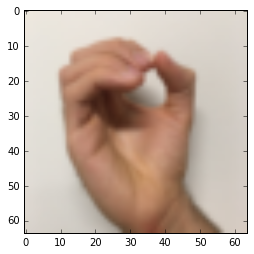

In [35]:
#examples of the pictures
index = 1
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:,index])))

In [42]:
#Flatten the training and test data
#convert the picture intio a vector
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1).T
print(X_train_flatten.shape)
print(X_train_orig.shape)
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1).T
print(X_test_flatten.shape)
print(X_test_orig.shape)

(12288, 1080)
(1080, 64, 64, 3)
(12288, 120)
(120, 64, 64, 3)


In [43]:
# Normalize the image vector
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

In [44]:
# Convert the training and test labels to one_hot matrix
Y_train = convert_to_one_hot(Y_train_orig,6)
Y_test = convert_to_one_hot(Y_test_orig,6)

In [45]:
print("number of training examples = " + str(X_train.shape[1]))
print("number of test examples = " + str(X_test.shape[1]))
print("X_train shape " + str(X_train.shape))
print("Y_train shape " + str(Y_train.shape))
print("X_test shape " + str(X_test.shape))
print("Y_test shape " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape (12288, 1080)
Y_train shape (6, 1080)
X_test shape (12288, 120)
Y_test shape (6, 120)


In [50]:
"""
Create placeholders
"""
def create_placeholder(n_x,n_y):
    X = tf.placeholder(shape = [n_x,None],dtype = tf.float32)
    Y = tf.placeholder(shape = [n_y,None],dtype = tf.float32)
    return X,Y

In [51]:
X,Y = create_placeholder(12288,6)
print("X " + str(X))
print("X " + str(X.shape))
print("Y " + str(Y))
print("Y " + str(Y.shape))

X Tensor("Placeholder:0", shape=(12288, ?), dtype=float32)
X (12288, ?)
Y Tensor("Placeholder_1:0", shape=(6, ?), dtype=float32)
Y (6, ?)


In [57]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [25,12288],initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1],initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))  
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())  
    W3 = tf.get_variable("W3", [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))  
    b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())  
    
    parameters = {"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
    return parameters

In [58]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1" + str(parameters["W1"]))
    print("b1" + str(parameters["b1"]))
    print("W2" + str(parameters["W2"]))
    print("b2" + str(parameters["b2"]))

W1<tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1<tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2<tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2<tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [63]:
def forward_propagation(X,parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3

In [64]:
tf.reset_default_graph()

with tf.Session() as sess:
    X,Y = create_placeholder(12288,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


In [71]:
"""
compute cost
"""
def compute_cost(Z3,Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = labels))
    return cost

In [72]:
tf.reset_default_graph()
with tf.Session() as sess:
    X,Y = create_placeholder(12288,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [89]:
"""
backward propagation and parameter updates
"""
def model(X_train,Y_train,X_test,T_test,learning_rate=0.0001,num_epochs = 1500,
         minibatch_size = 32, print_cost = True):
    # tf.reset_default_graph函数用于清除默认图形堆栈并重置全局默认图形
    ops.reset_default_graph()
    # to keep consistent results
    tf.set_random_seed(1)
    seed = 3
    # (n_x: input size, m : number of examples in the train set)
    (n_x,m) = X_train.shape
    # n_y : output size
    n_y = Y_train.shape[0]
    # To keep track of the cost
    costs = []
    X,Y = create_placeholder(n_x,n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train,Y_train,minibatch_size,seed)
            # 将整个训练集分成minibatch，迭代一遍训练集并返回cost
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.  
                 # Run the session to execute the "optimizer" and the "cost", 
                 # the feedict should contain a minibatch for (X,Y).
                _,minibatch_cost = sess.run([optimizer,cost],feed_dict = {X:minibatch_X,
                                                                         Y:minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches
            # %i十进制整数,%f浮点数 
            if print_cost == True and epoch % 100 == 0:
                print("Cost after epoch %i: %f" % (epoch,epoch_cost))
            if print_cost == True and epoch % 5 ==0:
                costs.append(epoch_cost)
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations(per.tens)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show
         # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
        
        # Calculate the correct predictions  
        correct_prediction = tf.equal(tf.argmax(Z3),tf.argmax(Y))

        # Calculate accuracy on the test set 
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        
        print("Train accuracy:", accuracy.eval({X:X_train,Y:Y_train}))
        print("Test accuracy:", accuracy.eval({X:X_test,Y:Y_test}))
        
        return parameters       

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102
Cost after epoch 300: 0.572938
Cost after epoch 400: 0.468799
Cost after epoch 500: 0.380979
Cost after epoch 600: 0.313819
Cost after epoch 700: 0.254258
Cost after epoch 800: 0.203795
Cost after epoch 900: 0.166410
Cost after epoch 1000: 0.141497
Cost after epoch 1100: 0.107579
Cost after epoch 1200: 0.086229
Cost after epoch 1300: 0.059415
Cost after epoch 1400: 0.052237
Parameters have been trained!
Train accuracy: 0.9990741
Test accuracy: 0.71666664


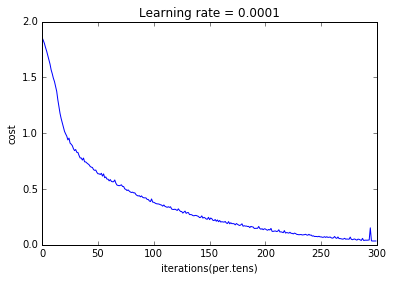

In [90]:
parameters = model(X_train,Y_train,X_test,Y_test)